In [1]:
import ccxt
import pandas as pd
import numpy as np
import time
import ta
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

In [2]:
import ccxt
import pandas as pd
import time
import ta

symbol = "BTC/USDT"
exchange_id = "binance"
ohlcv_timeframe = "1h"  # CCXT timeframe

def fetch_ohlcv(symbol, exchange_id, timeframe, since=None, limit=1000, max_bars=100000):
    exchange = getattr(ccxt, exchange_id)()
    exchange.load_markets()

    all_bars = []
    fetch_since = since if since else exchange.milliseconds() - (max_bars * 60 * 1000)  # Default: fetch last max_bars minutes

    while len(all_bars) < max_bars:
        try:
            new_bars = exchange.fetch_ohlcv(symbol, timeframe, since=fetch_since, limit=limit)

            if not new_bars:
                print("No new bars returned. Stopping...")
                break  # Stop if no new data is returned

            all_bars.extend(new_bars)  # Append new data
            print(f"Fetched {len(new_bars)} bars, Total: {len(all_bars)}")

            fetch_since = new_bars[-1][0] + 1  # Move `since` forward

            if len(new_bars) < limit:
                print("Last batch returned less than the limit. Likely at the end of data.")
                break  # Stop if no more data is available
            
            time.sleep(exchange.rateLimit / 1000)  # Avoid API rate limits
            
        except Exception as e:
            print(f"Error fetching data: {e}")
            break
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Add technical indicators
    df["SMA_20"] = ta.trend.sma_indicator(df["close"], window=20)  # 20-period SMA
    df["SMA_50"] = ta.trend.sma_indicator(df["close"], window=50)  # 50-period SMA
    df["EMA_20"] = ta.trend.ema_indicator(df["close"], window=20)  # 20-period EMA
    df["RSI_14"] = ta.momentum.rsi(df["close"], window=14)  # RSI (Relative Strength Index)
    df["MACD"] = ta.trend.macd(df["close"])  # MACD Line
    df["MACD_Signal"] = ta.trend.macd_signal(df["close"])  # MACD Signal Line
    df["ATR_14"] = ta.volatility.average_true_range(df["high"], df["low"], df["close"], window=14)  # ATR
    
    df.dropna(inplace=True)
    
    print(f"Final data count: {len(df)} bars")
    return df

# Example usage:
df = fetch_ohlcv(symbol, exchange_id, ohlcv_timeframe, max_bars=100000)

Fetched 1000 bars, Total: 1000
Fetched 667 bars, Total: 1667
Last batch returned less than the limit. Likely at the end of data.
Final data count: 1618 bars


In [3]:
def detect_trend(df):
    # Ensure there is enough data
    if len(df) < 50:
        print("Not enough data to determine trend.")
        return None

    # Moving Averages
    ma_bullish = df["SMA_20"].iloc[-1] > df["SMA_50"].iloc[-1]
    ma_bearish = df["SMA_20"].iloc[-1] < df["SMA_50"].iloc[-1]

    # MACD
    macd_bullish = df["MACD"].iloc[-1] > df["MACD_Signal"].iloc[-1]
    macd_bearish = df["MACD"].iloc[-1] < df["MACD_Signal"].iloc[-1]

    # RSI
    rsi_bullish = df["RSI_14"].iloc[-1] > 55
    rsi_bearish = df["RSI_14"].iloc[-1] < 45

    # ATR (Volatility Strength)
    atr_bullish = df["ATR_14"].iloc[-1] > df["ATR_14"].rolling(10).mean().iloc[-1]
    atr_bearish = df["ATR_14"].iloc[-1] < df["ATR_14"].rolling(10).mean().iloc[-1]

    # Count bullish & bearish signals
    bullish_signals = sum([ma_bullish, macd_bullish, rsi_bullish, atr_bullish])
    bearish_signals = sum([ma_bearish, macd_bearish, rsi_bearish, atr_bearish])

    # Determine final trend
    if bullish_signals >= 3:
        trend = "Bullish"
    elif bearish_signals >= 3:
        trend = "Bearish"
    else:
        trend = "Sideways / Neutral"

    print(f"Market Trend: {trend} (Bullish signals: {bullish_signals}, Bearish signals: {bearish_signals})")
    return trend

# Example usage:
trend_results = []

for i in range(50, len(df)):  # Start from 50 to ensure enough historical data
    trend_results.append(detect_trend(df.iloc[:i]))  # Run trend detection on past data

# Add the trend results as a new column
df = df.iloc[50:].copy()  # Trim the first 50 rows to match trend output
df["Trend"] = trend_results

Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bull

Market Trend: Bullish (Bullish signals: 3, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Bullish (Bullish signals: 3, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Bullish (Bullish signals: 4, Bearish signals: 0)
Market Trend: Bullish (Bullish signals: 4, Bearish signals: 0)
Market Trend: Bullish (Bullish signals: 4, Bearish signals: 0)
Market Trend: Bullish (Bullish signals: 4, Bearish signals: 0)
Market Trend: Bullish (Bullish

Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 1

Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 0, Bearish signals: 4)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bullish (Bullish signals: 3, B

Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 1, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 1)
Market Trend: Sideways / Neutral (Bullish signals: 2, Bearish signals: 2)
Market Trend: Bearish (Bullish signals: 1, Bearish signals: 3)
Market Trend: Bearish (Bullish signals: 1, Bearis

In [4]:
trend_mapping = {"Bullish": 1, "Bearish": 2, "Sideways / Neutral": 0}

df["Trend"] = df["Trend"].replace(trend_mapping)

C:\Users\WIN10\AppData\Local\Temp\ipykernel_18572\1432494969.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Trend"] = df["Trend"].replace(trend_mapping)


In [5]:
count_trend_1 = (df["Trend"] == 1).sum()
count_trend_neg1 = (df["Trend"] == 2).sum()
count_trend_0 = (df["Trend"] == 0).sum()

print(f"Uptrend (1): {count_trend_1}")
print(f"Downtrend (-1): {count_trend_neg1}")
print(f"Neutral (0): {count_trend_0}")

Uptrend (1): 331
Downtrend (-1): 457
Neutral (0): 780


In [6]:
df.to_csv("trend.csv", index=False)

In [7]:
df = pd.read_csv("trend.csv")

# Normalize Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Define the features to normalize (excluding 'timestamp' and 'Trend')
feature_columns = df.columns[1:-1]  # Exclude 'timestamp' and 'Trend'
target_column = "Trend"

# Initialize the scaler
scaler = MinMaxScaler()

import joblib
joblib.dump(scaler, "Trend.pkl")

# Normalize the feature data
df_scaled = df.copy()
df_scaled[feature_columns] = scaler.fit_transform(df[feature_columns])
df_scaled

,timestamp,open,high,low,close,volume,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_Signal,ATR_14,Trend
0,2025-01-11 03:00:00,0.546849,0.502311,0.561372,0.539763,0.012320,0.575222,0.537557,0.558689,0.492086,0.471683,0.511797,0.265827,0
1,2025-01-11 04:00:00,0.539763,0.498576,0.552558,0.535078,0.021339,0.574048,0.536964,0.557337,0.472678,0.460912,0.505398,0.255468,0
2,2025-01-11 05:00:00,0.535078,0.500710,0.558389,0.544972,0.009604,0.573237,0.537245,0.557224,0.518194,0.457904,0.499577,0.241634,0
3,2025-01-11 06:00:00,0.544973,0.502706,0.564893,0.540066,0.003910,0.571336,0.537072,0.556572,0.495964,0.452526,0.493664,0.223666,0
4,2025-01-11 07:00:00,0.540067,0.499142,0.562816,0.541048,0.006861,0.569762,0.536884,0.556091,0.500838,0.448728,0.488047,0.205400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,2025-03-17 06:00:00,0.178210,0.136722,0.194923,0.181500,0.037034,0.138341,0.117485,0.131152,0.486504,0.407870,0.401332,0.161088,0
1564,2025-03-17 07:00:00,0.181500,0.147927,0.211931,0.192815,0.042355,0.140544,0.116904,0.132100,0.545704,0.416388,0.406630,0.156015,0
1565,2025-03-17 08:00:00,0.192815,0.150653,0.212198,0.192140,0.028244,0.142049,0.116375,0.132882,0.541914,0.422940,0.412399,0.153999,0
1566,2025-03-17 09:00:00,0.192140,0.152743,0.218932,0.195960,0.030873,0.144081,0.116240,0.134019,0.562523,0.430453,0.418768,0.146848,0


In [9]:
df_scaled = df_scaled.iloc[:, 1:]

X = df_scaled.drop(columns = ['Trend']).values
y = df_scaled['Trend'].values
y = to_categorical(y, num_classes=3)

In [10]:
sequence_length = 30

In [11]:
X_sequences, y_sequences = [], []
for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i + sequence_length])
    y_sequences.append(y[i + sequence_length])
    
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [12]:
train_size = int(0.8 * len(X_sequences))
val_size = int(0.15 * len(X_sequences))

X_train, y_train = X_sequences[:train_size], y_sequences[:train_size]
X_val, y_val = X_sequences[train_size:train_size + val_size], y_sequences[train_size:train_size + val_size]
X_test, y_test = X_sequences[train_size + val_size:], y_sequences[train_size + val_size:]

In [13]:
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [14]:
def trainNN(X_train, y_train, X_val, y_val, epochs=200, learning_rate=0.0001, batch_size=256):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.0005), input_shape=(X_train.shape[1], X_train.shape[2]))),
        Dropout(0.3),  # Increased dropout
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
        Dropout(0.3),  # Increased dropout
        Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.3),  # Increased dropout
        Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.3),  # Increased dropout
        Dense(3, activation='softmax')  # 3 classes: Bearish, Bullish, Neutral
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('trend_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  # Increased patience

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, early_stop], verbose=1)
    
    return model, history


Epoch 1/200


C:\Users\WIN10\my-ai-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.3628 - loss: 2.7958
Epoch 1: val_loss improved from inf to 2.70608, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 892ms/step - accuracy: 0.3645 - loss: 2.7941 - val_accuracy: 0.4652 - val_loss: 2.7061
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.3966 - loss: 2.7262
Epoch 2: val_loss improved from 2.70608 to 2.69114, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - accuracy: 0.3983 - loss: 2.7248 - val_accuracy: 0.4652 - val_loss: 2.6911
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.4765 - loss: 2.6410
Epoch 3: val_loss improved from 2.69114 to 2.67505, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.4757 - loss: 2.6399 - val_accuracy: 0.4652 - val_loss: 2.6750
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4702 - loss: 2.6222
Epoch 4: val_loss improved from 2.67505 to 2.65897, saving model to tren

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6108 - loss: 2.1440
Epoch 24: val_loss improved from 2.38507 to 2.36762, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step - accuracy: 0.6151 - loss: 2.1401 - val_accuracy: 0.4913 - val_loss: 2.3676
Epoch 25/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6438 - loss: 2.1099
Epoch 25: val_loss improved from 2.36762 to 2.35789, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step - accuracy: 0.6430 - loss: 2.1090 - val_accuracy: 0.4522 - val_loss: 2.3579
Epoch 26/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6193 - loss: 2.0885
Epoch 26: val_loss improved from 2.35789 to 2.34572, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.6185 - loss: 2.0904 - val_accuracy: 0.4304 - val_loss: 2.3457
Epoch 27/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6302 - loss: 2.0574
Epoch 27: val_loss improved from 2.34572 to 2.32309, saving mod

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6990 - loss: 1.7581
Epoch 47: val_loss improved from 2.01296 to 1.99744, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - accuracy: 0.6993 - loss: 1.7552 - val_accuracy: 0.6261 - val_loss: 1.9974
Epoch 48/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7100 - loss: 1.7173
Epoch 48: val_loss improved from 1.99744 to 1.96937, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.7108 - loss: 1.7166 - val_accuracy: 0.6783 - val_loss: 1.9694
Epoch 49/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7057 - loss: 1.7053
Epoch 49: val_loss improved from 1.96937 to 1.95095, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.7073 - loss: 1.7061 - val_accuracy: 0.6696 - val_loss: 1.9510
Epoch 50/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7283 - loss: 1.6731
Epoch 50: val_loss improved from 1.95095 to 1.94043, saving mod

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7514 - loss: 1.4362
Epoch 70: val_loss improved from 1.61514 to 1.59128, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step - accuracy: 0.7493 - loss: 1.4393 - val_accuracy: 0.7478 - val_loss: 1.5913
Epoch 71/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7554 - loss: 1.4315
Epoch 71: val_loss improved from 1.59128 to 1.57189, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - accuracy: 0.7558 - loss: 1.4302 - val_accuracy: 0.7609 - val_loss: 1.5719
Epoch 72/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7511 - loss: 1.4419
Epoch 72: val_loss improved from 1.57189 to 1.55906, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.7527 - loss: 1.4427 - val_accuracy: 0.7522 - val_loss: 1.5591
Epoch 73/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7730 - loss: 1.3988
Epoch 73: val_loss improved from 1.55906 to 1.54891, saving mod

Epoch 94/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7777 - loss: 1.2519
Epoch 94: val_loss improved from 1.31550 to 1.30985, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step - accuracy: 0.7799 - loss: 1.2498 - val_accuracy: 0.7783 - val_loss: 1.3098
Epoch 95/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7922 - loss: 1.2395
Epoch 95: val_loss improved from 1.30985 to 1.28897, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.7930 - loss: 1.2401 - val_accuracy: 0.8087 - val_loss: 1.2890
Epoch 96/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7841 - loss: 1.2668
Epoch 96: val_loss did not improve from 1.28897
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - accuracy: 0.7847 - loss: 1.2629 - val_accuracy: 0.7957 - val_loss: 1.2943
Epoch 97/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8064 - loss: 1.2231
Epoch 97: val_loss did not improve from 1.28897
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step - 

Epoch 118/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8130 - loss: 1.1109
Epoch 118: val_loss did not improve from 1.14093
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step - accuracy: 0.8126 - loss: 1.1096 - val_accuracy: 0.8087 - val_loss: 1.1457
Epoch 119/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7988 - loss: 1.1244
Epoch 119: val_loss did not improve from 1.14093
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.7978 - loss: 1.1229 - val_accuracy: 0.7913 - val_loss: 1.1491
Epoch 120/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8129 - loss: 1.1148
Epoch 120: val_loss did not improve from 1.14093
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step - accuracy: 0.8135 - loss: 1.1128 - val_accuracy: 0.7826 - val_loss: 1.1670
Epoch 121/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7807 - loss: 1.1206
Epoch 121: val_loss did not improve from 1.14093
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.7808 - loss: 1.1203 - val_accuracy: 0.7783 - val_loss: 1.1

Epoch 143/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8334 - loss: 0.9663
Epoch 143: val_loss did not improve from 1.01745
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - accuracy: 0.8312 - loss: 0.9697 - val_accuracy: 0.8087 - val_loss: 1.0474
Epoch 144/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8452 - loss: 0.9715
Epoch 144: val_loss did not improve from 1.01745
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.8432 - loss: 0.9736 - val_accuracy: 0.8174 - val_loss: 1.0531
Epoch 145/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8257 - loss: 0.9881
Epoch 145: val_loss did not improve from 1.01745
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step - accuracy: 0.8249 - loss: 0.9883 - val_accuracy: 0.7870 - val_loss: 1.0804
Epoch 146/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8289 - loss: 0.9796
Epoch 146: val_loss did not improve from 1.01745
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 708ms/step - accuracy: 0.8265 - loss: 0.9852 - val_accuracy: 0.7435 - val_loss: 1.1

Epoch 168/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8464 - loss: 0.9065
Epoch 168: val_loss improved from 0.96053 to 0.92694, saving model to trend_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - accuracy: 0.8442 - loss: 0.9096 - val_accuracy: 0.8478 - val_loss: 0.9269
Epoch 169/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8338 - loss: 0.8877
Epoch 169: val_loss did not improve from 0.92694
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.8320 - loss: 0.8894 - val_accuracy: 0.7870 - val_loss: 1.0376
Epoch 170/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8389 - loss: 0.8965
Epoch 170: val_loss did not improve from 0.92694
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step - accuracy: 0.8379 - loss: 0.8976 - val_accuracy: 0.8435 - val_loss: 0.9503
Epoch 171/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8395 - loss: 0.8892
Epoch 171: val_loss did not improve from 0.92694
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step - accuracy: 0.8376 - loss: 0.8909

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8468 - loss: 0.8383
Epoch 193: val_loss did not improve from 0.89480
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - accuracy: 0.8458 - loss: 0.8398 - val_accuracy: 0.8478 - val_loss: 0.9014
Epoch 194/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8494 - loss: 0.8365
Epoch 194: val_loss did not improve from 0.89480
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step - accuracy: 0.8501 - loss: 0.8335 - val_accuracy: 0.8261 - val_loss: 0.9434
Epoch 195/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8595 - loss: 0.8308
Epoch 195: val_loss did not improve from 0.89480
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.8591 - loss: 0.8308 - val_accuracy: 0.8391 - val_loss: 0.9192
Epoch 196/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.8493 - loss: 0.8216
Epoch 196: val_loss did not improve from 0.89480
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - accuracy: 0.8490 - loss: 0.8216 - val_accuracy: 0.8304 - val_loss: 0.9167
Epoch 197/

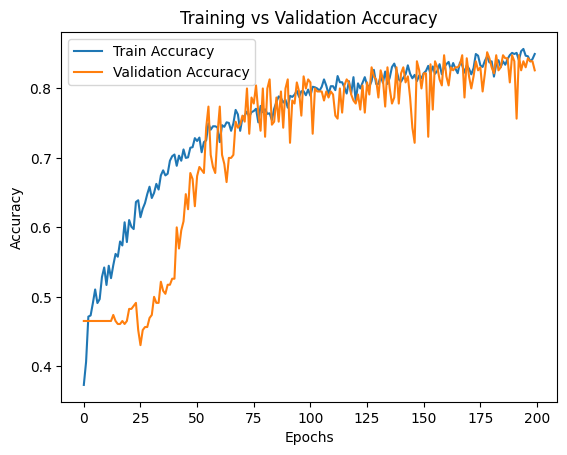

In [15]:
# Train the model with validation set
model, history = trainNN(X_train, y_train, X_val, y_val)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [16]:
# Load best saved model
model = load_model('trend_model.keras')


# Predict on the test set
predictions = model.predict(X_test)
pred_labels = np.argmax(predictions, axis = 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step


(1568, 14)
(78,)
(78,)
    Predicted  Actual
0           0       1
1           0       0
2           0       0
3           0       1
4           0       0
5           0       0
6           0       1
7           0       0
8           0       0
9           0       1
10          1       0
11          1       0
12          1       1
13          1       0
14          1       0
15          1       1
16          1       0
17          1       0
18          1       1
19          1       0


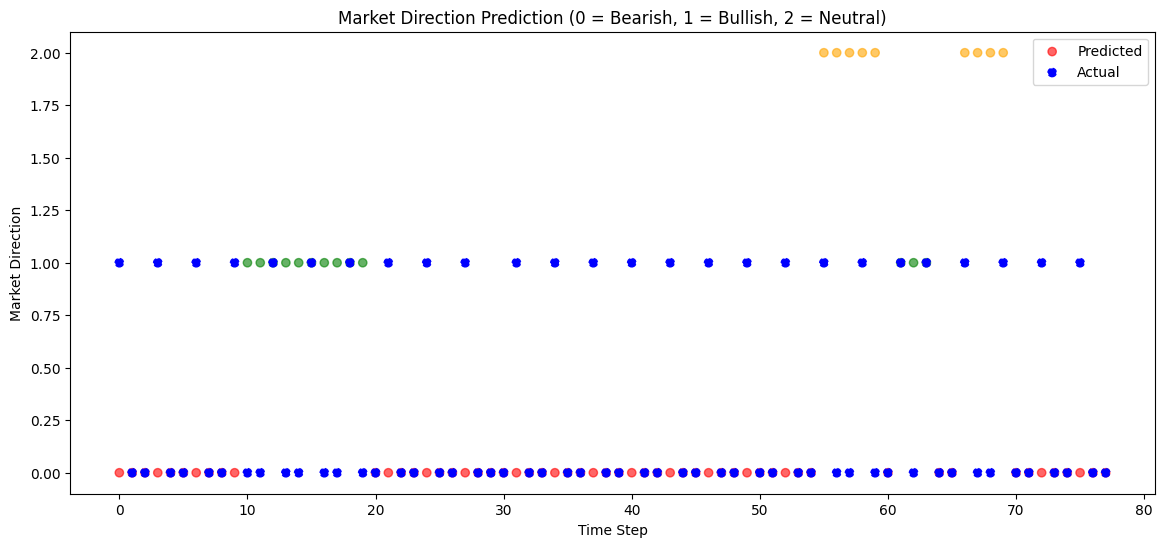

In [17]:
# Ensure predictions and actual labels are NumPy arrays and 1D
y_test_labels = np.array(y_test).flatten().astype(int)  # Convert to 1D integer array
pred_labels = np.array(pred_labels).flatten().astype(int)  # Convert to 1D integer array

min_len = min(len(pred_labels), len(y_test_labels))
pred_labels = pred_labels[:min_len]
y_test_labels = y_test_labels[:min_len]

print(df.shape)
print(y_test_labels.shape)
print(pred_labels.shape)
# Ensure both arrays are 1D
if y_test_labels.ndim != 1 or pred_labels.ndim != 1:
    raise ValueError(f"y_test_labels and pred_labels must be 1D arrays. Found shapes: {y_test_labels.shape}, {pred_labels.shape}")

# Display Predictions vs. Actual
df_results = pd.DataFrame({'Predicted': pred_labels, 'Actual': y_test_labels})
print(df_results.head(20))  # Show first 20 comparisons

# === Visualization ===
plt.figure(figsize=(14, 6))

# Color Mapping for Multi-Class Predictions
color_map = {0: 'red', 1: 'green', 2: 'orange'}  # Assign colors to classes
colors = [color_map[x] for x in pred_labels]  # Assign color based on predicted class

# Scatter Plot for Predictions (Class 0 = Red, Class 1 = Green, Class 2 = Orange)
plt.scatter(range(len(pred_labels)), pred_labels, label='Predicted', c=colors, marker='o', alpha=0.6)

# Line Plot for Actual Values
plt.scatter(range(len(y_test_labels)), y_test_labels, label='Actual', linestyle='dashed', color='blue')

plt.title("Market Direction Prediction (0 = Bearish, 1 = Bullish, 2 = Neutral)")
plt.xlabel("Time Step")
plt.ylabel("Market Direction")
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, pred_labels)

# Display accuracy
accuracy

0.5641025641025641

In [60]:
morel2_model = 0.7895500725689405

In [61]:
dropout128_model = 0.7852960312296682

In [62]:
test_model = 0.7812922276162354